# E‑ConvNeXt Image Classification Pipeline

This notebook presents a unified image classification workflow built around the E‑ConvNeXt architecture. It brings together several pieces of functionality from separate notebooks and scripts into one cohesive pipeline:

* **Automated data splitting:** given a root directory of images, the notebook can automatically split the data into training, validation and test sets (70/15/15 split by default).
* **Exploratory Data Analysis (EDA):** before training, the notebook scans the dataset and visualises key characteristics such as class distribution, image dimensions, aspect ratios and brightness. Example images are also shown.
* **E‑ConvNeXt model definition and training:** the core model, training loop and evaluation functions are adapted from the *E‑ConvNeXt Notebook Guide‑FULLPIPELINE* to provide a configurable classification backbone. Training history is plotted using a consistent blue‑gradient colour palette.

To use this notebook with your own data, set the `dataset_root` variable in the next code cell to point to your image folder. The folder can either contain class sub‑directories directly or be organised into `train`, `val`/`validation` and `test` folders. Once the dataset is split and loaded, the notebook will run EDA, train the E‑ConvNeXt model and provide evaluation metrics and visualisations.

In [1]:
# Install required libraries (uncomment if running locally)
# !pip install torch torchvision timm numpy pandas matplotlib seaborn scikit-learn

import os
import shutil
import random
import math
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {device}')

DEFAULT_COLOR = '#1f77b4'
sns.set_palette([DEFAULT_COLOR])

Using Device: cuda


## Automated Dataset Splitting

The following function inspects a dataset directory and organises it into `train`, `val` and `test` sub‑folders on disk.

* If the root contains only class sub‑folders, a 70/15/15 split is created.
* If only `train` and `val` directories exist, their contents are combined and re‑split into `train`, `val` and `test`.
* If `train` and `test` directories exist, they are left untouched (no validation split).
* If `train`, `val` and `test` are present, no splitting is performed.

You can adjust the `train_ratio`, `val_ratio` and `test_ratio` arguments to change the default 70/15/15 proportions.

In [2]:
def split_dataset(base_dir: str, train_ratio: float = 0.70, val_ratio: float = 0.15, test_ratio: float = 0.15, seed: int = 42) -> None:
    """
    Split a dataset of images on disk. The function operates in four modes based on folder structure:

    1. When the root contains only class sub‑folders (no `train`/`val`/`test`), a new `train`/`val`/`test` split is created.
    2. When `train` and `val` folders exist, their contents are combined and re‑split into `train`/`val`/`test`.
    3. When `train` and `test` exist, they are left untouched and no validation set is created.
    4. When `train`, `val` and `test` exist, the directory structure is assumed correct and nothing is changed.

    Parameters
    ----------
    base_dir : str
        Path to the dataset root.
    train_ratio : float
        Proportion of samples to allocate to the training set when performing a new split.
    val_ratio : float
        Proportion of samples to allocate to the validation set when performing a new split.
    test_ratio : float
        Proportion of samples to allocate to the test set when performing a new split.
    seed : int
        Random seed for reproducibility.
    """
    random.seed(seed)
    root = os.path.abspath(base_dir)
    train_dir = os.path.join(root, 'train')
    val_dir = os.path.join(root, 'val')
    test_dir = os.path.join(root, 'test')

    def _ensure_empty(dir_path: str) -> None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        else:
            for item in os.listdir(dir_path):
                shutil.rmtree(os.path.join(dir_path, item))

    has_train = os.path.isdir(train_dir)
    has_val = os.path.isdir(val_dir)
    has_test = os.path.isdir(test_dir)

    # Case 1: single folder of class sub‑directories
    if not has_train and not has_val and not has_test:
        print('[INFO] No train/val/test directories detected. Creating a 70/15/15 split.')
        classes = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        _ensure_empty(train_dir)
        _ensure_empty(val_dir)
        _ensure_empty(test_dir)
        for cls in classes:
            src_dir = os.path.join(root, cls)
            images = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
            random.shuffle(images)
            n_total = len(images)
            n_train = int(n_total * train_ratio)
            n_val = int(n_total * val_ratio)
            splits = {
                'train': images[:n_train],
                'val': images[n_train:n_train + n_val],
                'test': images[n_train + n_val:]
            }
            for split_name, files in splits.items():
                target_dir = os.path.join(root, split_name, cls)
                os.makedirs(target_dir, exist_ok=True)
                for fname in files:
                    shutil.copy2(os.path.join(src_dir, fname), os.path.join(target_dir, fname))
    # Case 2: train and val only → combine and re‑split
    elif has_train and has_val and not has_test:
        print('[INFO] Found train and val directories only. Combining and re‑splitting into train/val/test.')
        combined = {}
        for split_dir in [train_dir, val_dir]:
            for cls in os.listdir(split_dir):
                cls_dir = os.path.join(split_dir, cls)
                combined.setdefault(cls, []).extend([
                    os.path.join(cls_dir, f) for f in os.listdir(cls_dir)
                    if os.path.isfile(os.path.join(cls_dir, f))
                ])
        _ensure_empty(train_dir)
        _ensure_empty(val_dir)
        _ensure_empty(test_dir)
        for cls, files in combined.items():
            random.shuffle(files)
            n_total = len(files)
            n_train = int(n_total * train_ratio)
            n_val = int(n_total * val_ratio)
            splits = {
                'train': files[:n_train],
                'val': files[n_train:n_train + n_val],
                'test': files[n_train + n_val:]
            }
            for split_name, filepaths in splits.items():
                target_dir = os.path.join(root, split_name, cls)
                os.makedirs(target_dir, exist_ok=True)
                for src_path in filepaths:
                    shutil.copy2(src_path, os.path.join(target_dir, os.path.basename(src_path)))
    # Case 3: train and test only → do nothing
    elif has_train and not has_val and has_test:
        print('[INFO] Found train and test directories only. Leaving as‑is. No validation set will be created.')
    # Case 4: train, val and test exist → do nothing
    elif has_train and has_val and has_test:
        print('[INFO] Found train, val, and test directories. No splitting needed.')
    else:
        raise RuntimeError(f'[ERROR] Unrecognised layout under {root}. Expected combinations of train/val/test.')

### Configuration and Data Loading

The configuration below allows you to customise the dataset location, image resolution, model variant and training hyperparameters. After splitting the dataset, the `load_data` function loads the images into `torchvision.datasets.ImageFolder` datasets and constructs PyTorch dataloaders for the training and validation sets.

In [3]:
# Editable configuration
@dataclass
class Config:
    DATA_DIR: str = 'dataset/' # change this to your dataset root
    NUM_CLASSES: int = 10
    MODEL_VARIANT: str = 'tiny' # choose from 'mini', 'tiny', 'small'
    IMAGE_SIZE: int = 224
    BATCH_SIZE: int = 32
    EPOCHS: int = 10
    LEARNING_RATE: float = 2.5e-4
    WEIGHT_DECAY: float = 0.05
    
    # augmentation settings
    RAND_AUGMENT_N: int = 9
    RAND_AUGMENT_M: float = 0.5
    MIXUP_ALPHA: float = None
    CUTMIX_ALPHA: float = None

config = Config()

def get_transforms(cfg: Config):
    train_transforms = transforms.Compose([
        transforms.Resize(cfg.IMAGE_SIZE + 32),
        transforms.RandomCrop(cfg.IMAGE_SIZE),
        transforms.RandAugment(num_ops=cfg.RAND_AUGMENT_N, magnitude=int(cfg.RAND_AUGMENT_M * 10)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_transforms = transforms.Compose([
        transforms.Resize(cfg.IMAGE_SIZE + 32),
        transforms.CenterCrop(cfg.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return train_transforms, val_transforms

def load_data(cfg: Config):
    train_transforms, val_transforms = get_transforms(cfg)
    train_dir = os.path.join(cfg.DATA_DIR, 'train')
    val_dir = os.path.join(cfg.DATA_DIR, 'val')
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader, train_dataset.classes


## Exploratory Data Analysis (EDA)

The following helpers perform a lightweight scan of an image dataset and produce visual summaries. Statistics such as image width, height, aspect ratio, file size, brightness and colourfulness are collected. Plotting functions then visualise class distribution, dimension distributions, aspect ratios and other metrics. All charts use the same blue‑gradient palette for consistency.

In [4]:
from PIL import Image

def _colorfulness_fast(im: Image.Image) -> float:
    arr = np.asarray(im.convert('RGB'), dtype=np.float32)
    r, g, b = arr[..., 0], arr[..., 1], arr[..., 2]
    rg = np.abs(r - g)
    yb = np.abs(0.5 * (r + g) - b)
    return float(math.sqrt(rg.var() + yb.var()) + 0.3 * math.sqrt(rg.mean()**2 + yb.mean()**2))

def _brightness(im: Image.Image) -> float:
    return float(np.asarray(im.convert('L'), dtype=np.float32).mean())

def scan_image_dataset(data_path: str) -> pd.DataFrame:
    """
    Perform a scan over all images under `data_path` and return a DataFrame summarising their properties.

    The scan looks recursively for files with typical image extensions. For each image it records
    the label (sub‑directory name), optional split (train/val/test if present), dimensions, aspect ratio,
    file size (kilobytes), brightness and colourfulness.
    """
    img_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}
    records = []
    for root_dir, _, files in os.walk(data_path):
        for fname in files:
            if not any(fname.lower().endswith(ext) for ext in img_exts):
                continue
            fpath = os.path.join(root_dir, fname)
            try:
                with Image.open(fpath) as im:
                    w, h = im.size
                    mode = im.mode
                    brightness_value = _brightness(im)
                    colorfulness_value = _colorfulness_fast(im)
            except Exception:
                continue
            parts = os.path.normpath(fpath).split(os.sep)
            label = parts[-2] if len(parts) >= 2 else ''
            split = ''
            if label.lower() in {'train', 'val', 'validation', 'test'}:
                split = label.lower()
                label = parts[-3] if len(parts) >= 3 else label
            records.append({
                'path': fpath,
                'split': split,
                'label': label,
                'width': w,
                'height': h,
                'aspect': (w / h) if h > 0 else float('nan'),
                'file_size_kb': os.path.getsize(fpath) / 1024.0,
                'brightness': brightness_value,
                'colorfulness': colorfulness_value,
                'mode': mode
            })
    return pd.DataFrame(records)

def plot_class_distribution(df: pd.DataFrame) -> None:
    counts = df['label'].value_counts().sort_values(ascending=False)
    plt.figure(figsize=(max(6, 0.35 * len(counts) + 4), 4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.xticks(rotation=45, ha='right')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.show()

def plot_histogram(series: np.ndarray, bins: int, title: str, xlabel: str) -> None:
    plt.figure(figsize=(6, 4))
    plt.hist(series, bins=bins, color=sns.color_palette('Blues')[3])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.show()

def plot_scatter(x: np.ndarray, y: np.ndarray, title: str, xlabel: str, ylabel: str) -> None:
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, alpha=0.6, color=sns.color_palette('Blues')[4])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def show_random_images(df: pd.DataFrame, n: int = 9) -> None:
    n = min(n, len(df))
    indices = np.random.choice(len(df), size=n, replace=False)
    sample_paths = df.iloc[indices]['path'].tolist()
    grid_size = int(math.sqrt(n))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 3, grid_size * 3))
    for idx, path in enumerate(sample_paths):
        row = idx // grid_size
        col = idx % grid_size
        ax = axes[row, col]
        try:
            img = Image.open(path).convert('RGB')
            ax.imshow(img)
            ax.set_title(os.path.basename(os.path.dirname(path)), fontsize=8)
        except Exception:
            ax.axis('off')
            continue
        ax.axis('off')
    plt.suptitle('Random Image Samples')
    plt.tight_layout()
    plt.show()

def run_eda(data_path: str) -> pd.DataFrame:
    df = scan_image_dataset(data_path)
    if df.empty:
        print(f'No images found under: {data_path}')
        return df
    plot_class_distribution(df)
    plot_histogram(df['width'].values, bins=40, title='Image Width Distribution', xlabel='Width (pixels)')
    plot_histogram(df['height'].values, bins=40, title='Image Height Distribution', xlabel='Height (pixels)')
    aspects = df['aspect'].dropna().values
    plot_histogram(aspects, bins=40, title='Aspect Ratio Distribution', xlabel='Aspect ratio (W/H)')
    plot_histogram(df['file_size_kb'].values, bins=40, title='File Size Distribution', xlabel='File size (KB)')
    plot_histogram(df['brightness'].values, bins=40, title='Brightness Distribution', xlabel='Average grayscale value (0–255)')
    plot_scatter(df['width'].values, df['height'].values, title='Width vs Height', xlabel='Width (pixels)', ylabel='Height (pixels)')
    show_random_images(df, n=9)
    return df


## E‑ConvNeXt Model Architecture

The following cells define the E‑ConvNeXt architecture adapted from the reference implementation.
It comprises an Effective Squeeze‑and‑Excitation (ESE) block, a modified ConvNeXt block with Batch Normalisation, a Cross‑Stage Partial (CSP) stage and the overall model class.

In [5]:
# Effective Squeeze‑and‑Excitation block
class ESEBlock(nn.Module):
    def __init__(self, channels: int, reduction: int = 4):
        super().__init__()
        reduced_channels = max(1, channels // reduction)
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Conv2d(channels, reduced_channels, kernel_size=1, bias=True),
            nn.GELU(),
            nn.Conv2d(reduced_channels, channels, kernel_size=1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s = self.squeeze(x)
        e = self.excitation(s)
        return x * e

# E‑ConvNeXt block
class EConvNeXtBlock(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0):
        super().__init__()
        expanded_dim = int(dim * expansion_factor)
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.bn1 = nn.BatchNorm2d(dim)
        self.pwconv1 = nn.Conv2d(dim, expanded_dim, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(expanded_dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Conv2d(expanded_dim, dim, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(dim)
        self.ese = ESEBlock(dim)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.dwconv(x)
        x = self.bn1(x)
        x = self.pwconv1(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = self.bn3(x)
        x = self.ese(x)
        return x + residual

# CSP stage
class CSPStage(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, num_blocks: int, ch_mid: int = None):
        super().__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        if ch_mid is None:
            ch_mid = (in_channels + out_channels) // 2
        self.split_conv0 = nn.Sequential(
            nn.Conv2d(out_channels, ch_mid, kernel_size=1),
            nn.BatchNorm2d(ch_mid),
            nn.GELU()
        )
        self.split_conv1 = nn.Sequential(
            nn.Conv2d(out_channels, ch_mid, kernel_size=1),
            nn.BatchNorm2d(ch_mid),
            nn.GELU()
        )
        self.blocks = nn.Sequential(*[EConvNeXtBlock(ch_mid) for _ in range(num_blocks)])
        self.after_blocks = nn.Sequential(
            nn.Conv2d(ch_mid, ch_mid, kernel_size=1),
            nn.BatchNorm2d(ch_mid),
            nn.GELU()
        )
        self.merge_conv = nn.Sequential(
            nn.Conv2d(ch_mid * 2, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downsample(x)
        y1 = self.split_conv0(x)
        y2 = self.split_conv1(x)
        y2 = self.blocks(y2)
        y2 = self.after_blocks(y2)
        merged = torch.cat([y1, y2], dim=1)
        return self.merge_conv(merged)

def get_variant_config(variant: str):
    variant = variant.lower()
    if variant == 'mini':
        dims = [48, 96, 192, 384]
        depths = [3, 3, 9, 3]
    elif variant == 'tiny':
        dims = [64, 128, 256, 512]
        depths = [3, 3, 9, 3]
    elif variant == 'small':
        dims = [80, 160, 320, 640]
        depths = [3, 3, 27, 3]
    else:
        raise ValueError(f'Unknown variant: {variant}')
    return dims, depths

class EConvNeXt(nn.Module):
    def __init__(self, num_classes: int = 1000, variant: str = 'tiny'):
        super().__init__()
        dims, depths = get_variant_config(variant)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Conv2d(32, dims[0], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(dims[0]),
            nn.GELU(),
        )
        in_channels = dims[0]
        stages = []
        for out_channels, depth in zip(dims, depths):
            stages.append(CSPStage(in_channels, out_channels, num_blocks=depth))
            in_channels = out_channels
        self.stages = nn.Sequential(*stages)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Linear(dims[-1], num_classes)
        self.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        x = self.stages(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        return self.head(x)


## Training and Evaluation Functions

Here we implement the training loop, validation routine, history plotting and evaluation helpers.
Plots of the training history (loss and accuracy) use the same blue palette.

In [6]:
def train_one_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device) -> tuple:
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double().item() / total
    return epoch_loss, epoch_acc

def validate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, device: torch.device) -> tuple:
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
            total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double().item() / total
    return epoch_loss, epoch_acc

def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, cfg: Config, device: torch.device):
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.WEIGHT_DECAY)
    scheduler = CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS)
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(cfg.EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f'Epoch {epoch+1}/{cfg.EPOCHS}  |  Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f}  |  Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}')
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_econvnext_model.pth')
    print(f'Best validation accuracy: {best_acc:.4f}')
    return history

def plot_training_history(history: dict) -> None:
    epochs_range = range(1, len(history['train_loss']) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(epochs_range, history['train_loss'], label='Train Loss', color=sns.color_palette('Blues')[4])
    axes[0].plot(epochs_range, history['val_loss'], label='Val Loss', color=sns.color_palette('Blues')[2])
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curves')
    axes[0].legend()
    axes[1].plot(epochs_range, history['train_acc'], label='Train Acc', color=sns.color_palette('Blues')[4])
    axes[1].plot(epochs_range, history['val_acc'], label='Val Acc', color=sns.color_palette('Blues')[2])
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Curves')
    axes[1].legend()
    plt.show()

def evaluate_model(model: nn.Module, dataloader: DataLoader, class_names: list, device: torch.device) -> None:
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def load_model_for_inference(weight_path: str, num_classes: int, variant: str, device: torch.device) -> nn.Module:
    model = EConvNeXt(num_classes=num_classes, variant=variant)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict_image(model: nn.Module, image_path: str, cfg: Config, class_names: list, device: torch.device, topk: int = 5) -> None:
    transform = transforms.Compose([
        transforms.Resize(cfg.IMAGE_SIZE + 32),
        transforms.CenterCrop(cfg.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs[0], dim=0)
        top_probs, top_idxs = torch.topk(probs, k=min(topk, len(probs)))
    for i in range(len(top_probs)):
        print(f'{class_names[top_idxs[i].item()]}: {top_probs[i].item():.4f}')
    plt.imshow(img)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()


## Boosting Technique: Snapshot Ensemble

To improve model accuracy while considering the computational constraints of a laptop with i7 CPU and NVIDIA RTX 3050 GPU, we implement a **Snapshot Ensemble** boosting technique. This approach:

* **Saves multiple model snapshots** during training at specific epochs (when the cyclic learning rate reaches its minimum)
* **Combines predictions** from these snapshots through averaging to create a stronger ensemble
* **Optimized for laptop hardware**: Uses only a single training run, avoiding the computational cost of training multiple separate models
* **Balanced performance**: Provides accuracy improvements with minimal impact on training time and moderate inference overhead

The snapshot ensemble leverages the fact that models trained with cyclic learning rates converge to different local minima, creating diversity in the ensemble without the need for multiple full training runs.

In [ ]:
import time

def train_model_with_snapshots(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, cfg: Config, device: torch.device, n_snapshots: int = 3):
    """
    Train model with snapshot ensemble using cyclic learning rate.
    Saves model snapshots at local minima for ensemble boosting.
    
    Parameters
    ----------
    model : nn.Module
        The model to train
    train_loader : DataLoader
        Training data loader
    val_loader : DataLoader
        Validation data loader
    cfg : Config
        Configuration object
    device : torch.device
        Device to train on
    n_snapshots : int
        Number of snapshots to save (default: 3 for RTX 3050 memory efficiency)
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.WEIGHT_DECAY)
    
    # Cyclic learning rate scheduler for snapshot ensemble
    # T_0 determines cycle length - we use epochs/n_snapshots to get n_snapshots cycles
    cycle_length = max(1, cfg.EPOCHS // n_snapshots)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=cycle_length, T_mult=1)
    
    best_acc = 0.0
    snapshot_paths = []
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    training_start_time = time.time()
    
    for epoch in range(cfg.EPOCHS):
        epoch_start = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()
        epoch_time = time.time() - epoch_start
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{cfg.EPOCHS}  |  Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f}  |  '
              f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}  |  Time: {epoch_time:.2f}s')
        
        # Save snapshot at the end of each cycle (when LR is at minimum)
        if (epoch + 1) % cycle_length == 0 and len(snapshot_paths) < n_snapshots:
            snapshot_path = f'snapshot_model_{len(snapshot_paths)+1}.pth'
            torch.save(model.state_dict(), snapshot_path)
            snapshot_paths.append(snapshot_path)
            print(f'  → Saved snapshot {len(snapshot_paths)}/{n_snapshots}: {snapshot_path}')
        
        # Also keep track of best single model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_econvnext_model_boosted.pth')
    
    total_training_time = time.time() - training_start_time
    print(f'\nTraining completed in {total_training_time:.2f}s ({total_training_time/60:.2f} minutes)')
    print(f'Best single model validation accuracy: {best_acc:.4f}')
    print(f'Saved {len(snapshot_paths)} snapshots for ensemble')
    
    return history, snapshot_paths, total_training_time

def ensemble_predict(models: list, dataloader: DataLoader, device: torch.device) -> tuple:
    """
    Perform ensemble prediction by averaging logits from multiple models.
    
    Parameters
    ----------
    models : list
        List of trained models
    dataloader : DataLoader
        Data loader for inference
    device : torch.device
        Device to run inference on
    
    Returns
    -------
    tuple
        (all_predictions, all_labels) as numpy arrays
    """
    for model in models:
        model.eval()
    
    all_preds = []
    all_labels = []
    
    inference_start = time.time()
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            
            # Collect predictions from all models
            ensemble_logits = []
            for model in models:
                logits = model(inputs)
                ensemble_logits.append(logits)
            
            # Average the logits
            avg_logits = torch.stack(ensemble_logits).mean(dim=0)
            _, preds = torch.max(avg_logits, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    inference_time = time.time() - inference_start
    print(f'Ensemble inference time: {inference_time:.2f}s')
    print(f'Average time per batch: {inference_time/len(dataloader):.4f}s')
    
    return np.array(all_preds), np.array(all_labels)

def evaluate_ensemble(snapshot_paths: list, num_classes: int, variant: str, dataloader: DataLoader, class_names: list, device: torch.device) -> float:
    """
    Evaluate the snapshot ensemble on a dataset.
    
    Parameters
    ----------
    snapshot_paths : list
        List of paths to snapshot model weights
    num_classes : int
        Number of output classes
    variant : str
        Model variant ('mini', 'tiny', 'small')
    dataloader : DataLoader
        Data loader for evaluation
    class_names : list
        List of class names
    device : torch.device
        Device to run evaluation on
    
    Returns
    -------
    float
        Ensemble accuracy
    """
    print(f'\nLoading {len(snapshot_paths)} snapshot models for ensemble...')
    models = []
    for path in snapshot_paths:
        model = EConvNeXt(num_classes=num_classes, variant=variant)
        model.load_state_dict(torch.load(path, map_location=device))
        model.to(device)
        models.append(model)
    
    print('\nEnsemble Prediction Results:')
    all_preds, all_labels = ensemble_predict(models, dataloader, device)
    
    print('\nEnsemble Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Snapshot Ensemble')
    plt.show()
    
    # Calculate and display ensemble accuracy
    ensemble_acc = (all_preds == all_labels).mean()
    print(f'\nSnapshot Ensemble Accuracy: {ensemble_acc:.4f}')
    
    return ensemble_acc

## Full Pipeline Run: Baseline + Boosting

In this final section you can run the full pipeline including the snapshot ensemble boosting. The workflow consists of:

1. **Data preparation**: Split and load the dataset
2. **Exploratory Data Analysis**: Visualize dataset characteristics
3. **Baseline model training**: Train a single E‑ConvNeXt model
4. **Baseline evaluation**: Evaluate the single model performance
5. **Boosted model training**: Train with snapshot ensemble (cyclic LR)
6. **Ensemble evaluation**: Evaluate the snapshot ensemble
7. **Performance comparison**: Compare baseline vs boosted results

Replace `'path/to/your/dataset'` with the actual location of your image data. The boosting technique is optimized for laptop hardware (i7 + RTX 3050) and provides a good balance between accuracy improvement and computational efficiency.

In [8]:
# Specify your dataset root here. It may contain class sub‑folders directly or train/val/test splits.
dataset_root = config.DATA_DIR # update this variable before running

In [9]:
# Step 1: split the dataset (if required)
split_dataset(dataset_root, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, seed=SEED)

[INFO] Found train, val, and test directories. No splitting needed.


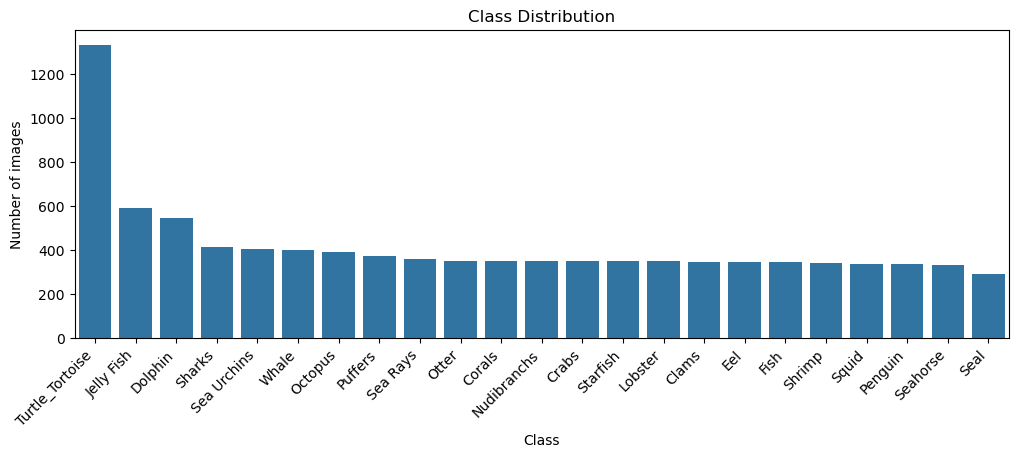

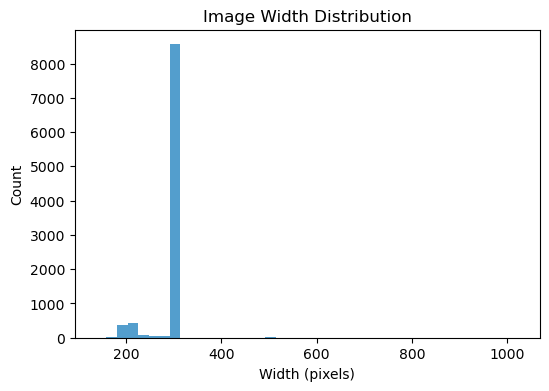

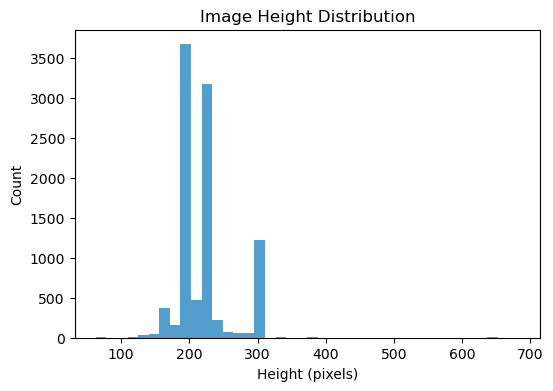

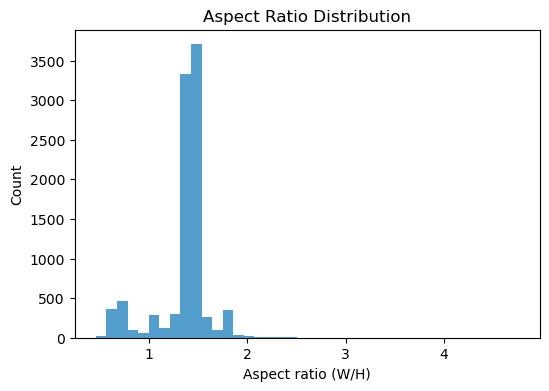

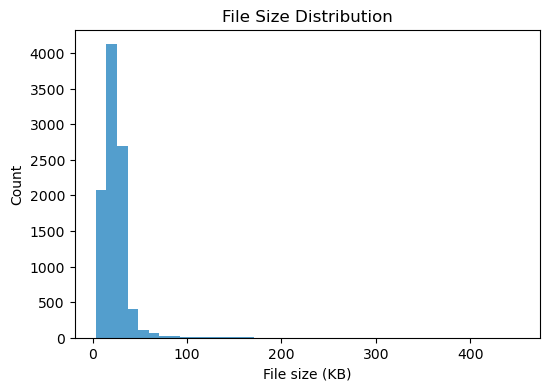

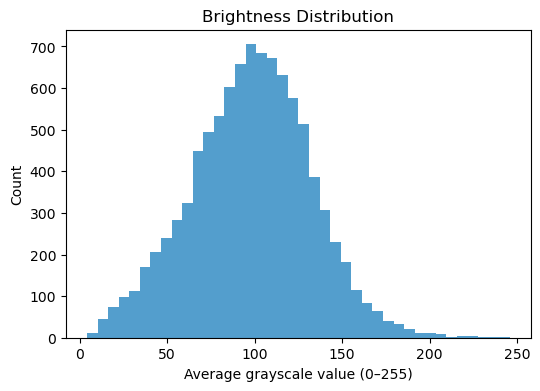

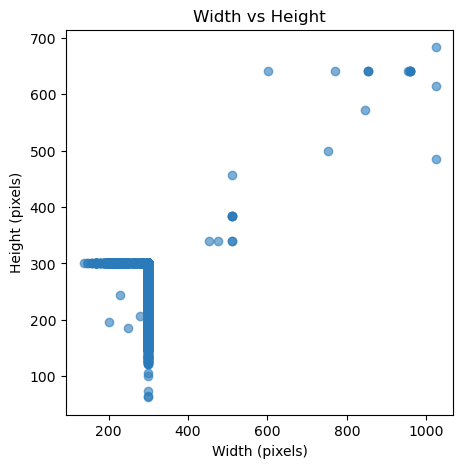

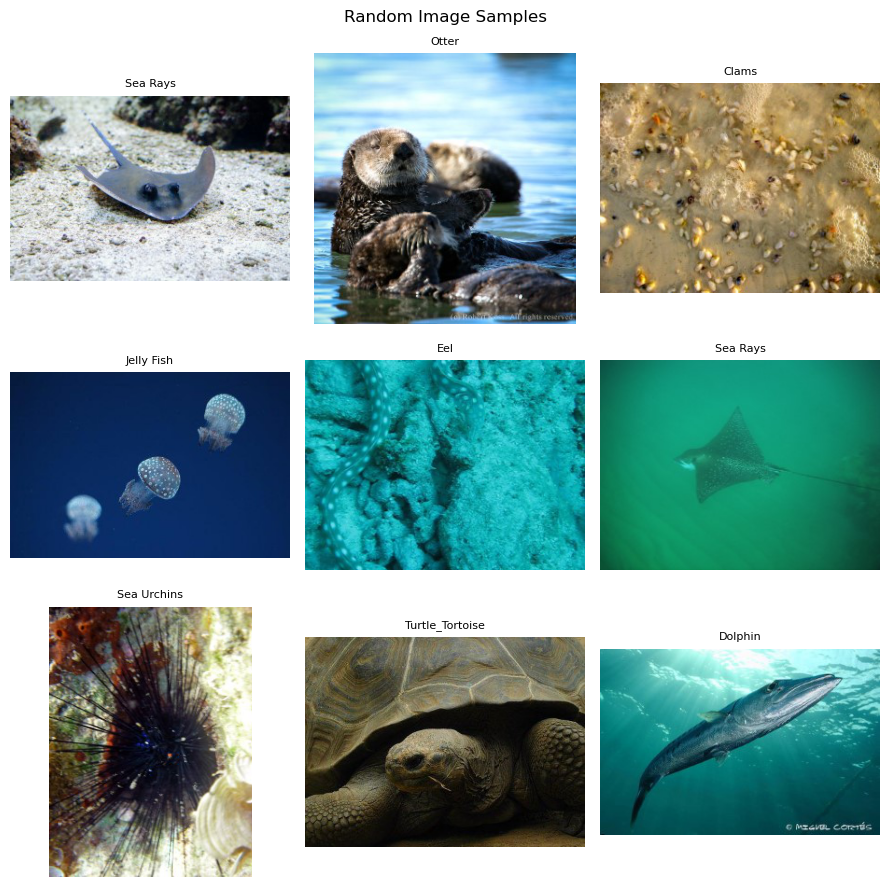

In [10]:
# Step 2: run EDA on the training set (or on the entire dataset)
train_path = os.path.join(dataset_root, 'train')
df_summary = run_eda(train_path)

In [11]:
# Step 3: load data for training and validation
train_loader, val_loader, class_names = load_data(config)
config.NUM_CLASSES = len(class_names)

print('[INFO] Baseline Model Trainging (Standard)')

[INFO] Baseline Model Trainging (Standard)


Epoch 1/10  |  Train Loss: 2.8875  Acc: 0.1677  |  Val Loss: 2.6871  Acc: 0.2346
Epoch 2/10  |  Train Loss: 2.6769  Acc: 0.2096  |  Val Loss: 2.4321  Acc: 0.2776
Epoch 3/10  |  Train Loss: 2.5367  Acc: 0.2363  |  Val Loss: 2.3258  Acc: 0.2874
Epoch 4/10  |  Train Loss: 2.4512  Acc: 0.2644  |  Val Loss: 2.2363  Acc: 0.3402
Epoch 5/10  |  Train Loss: 2.3568  Acc: 0.2887  |  Val Loss: 2.1352  Acc: 0.3514
Epoch 6/10  |  Train Loss: 2.2839  Acc: 0.3099  |  Val Loss: 2.0832  Acc: 0.3763
Epoch 7/10  |  Train Loss: 2.2171  Acc: 0.3302  |  Val Loss: 2.0125  Acc: 0.3886
Epoch 8/10  |  Train Loss: 2.1564  Acc: 0.3440  |  Val Loss: 1.9643  Acc: 0.4042
Epoch 9/10  |  Train Loss: 2.1283  Acc: 0.3502  |  Val Loss: 1.9262  Acc: 0.4062
Epoch 10/10  |  Train Loss: 2.0886  Acc: 0.3590  |  Val Loss: 1.9092  Acc: 0.4140
Best validation accuracy: 0.4140


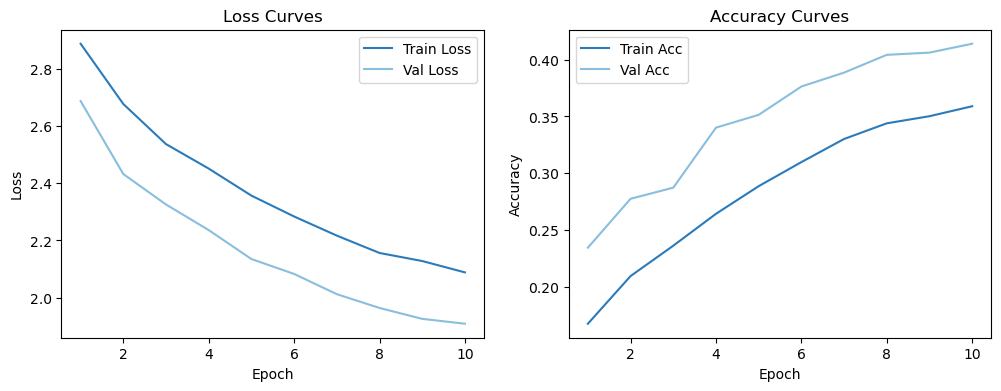

In [12]:
# Step 4: initialise and train baseline model (standard training)
baseline_model = EConvNeXt(num_classes=config.NUM_CLASSES, variant=config.MODEL_VARIANT).to(device)
baseline_history = train_model(baseline_model, train_loader, val_loader, config, device)
plot_training_history(baseline_history)

[INFO] Baseline Model Evaluation:


C:\Users\Rahfi\AppData\Local\Temp\ipykernel_18424\85276152.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=de

                 precision    recall  f1-score   support

          Clams       0.30      0.19      0.23        74
         Corals       0.29      0.44      0.35        75
          Crabs       0.44      0.80      0.57        74
        Dolphin       0.34      0.42      0.38       117
            Eel       0.15      0.03      0.05        74
           Fish       0.07      0.01      0.02        74
     Jelly Fish       0.53      0.71      0.61       126
        Lobster       0.26      0.27      0.26        74
    Nudibranchs       0.27      0.49      0.35        75
        Octopus       0.27      0.12      0.17        84
          Otter       0.67      0.80      0.73        75
        Penguin       0.33      0.26      0.29        72
        Puffers       0.24      0.06      0.10        79
       Sea Rays       0.32      0.08      0.12        77
    Sea Urchins       0.70      0.80      0.75        86
       Seahorse       0.34      0.38      0.36        71
           Seal       0.36    

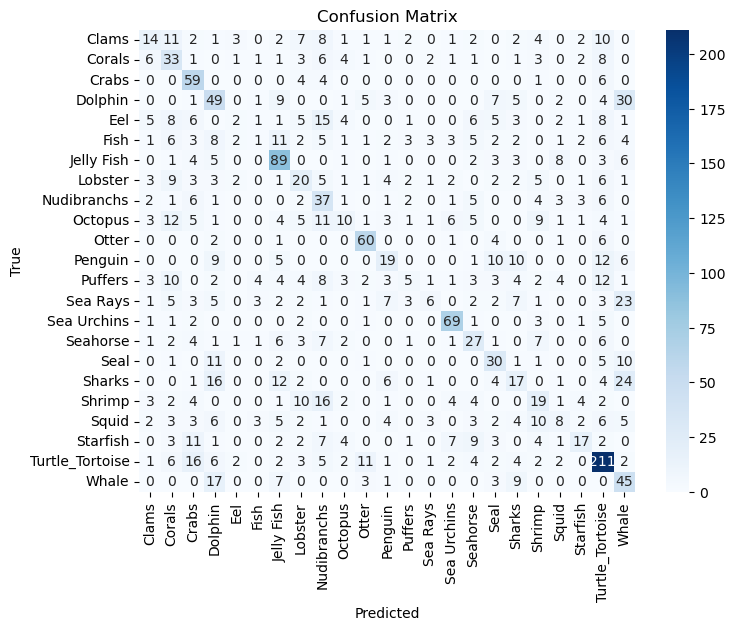

[INFO] Boosted Model Training (Snapshot Ensemble)


In [13]:
# Step 5: evaluate the baseline model on the validation set
print('[INFO] Baseline Model Evaluation:')
best_baseline_model = load_model_for_inference('best_econvnext_model.pth', num_classes=config.NUM_CLASSES, variant=config.MODEL_VARIANT, device=device)
evaluate_model(best_baseline_model, val_loader, class_names, device)

# Get baseline accuracy for comparison
baseline_val_acc = max(baseline_history['val_acc'])

print('[INFO] Boosted Model Training (Snapshot Ensemble)')

Epoch 1/10  |  Train Loss: 2.9101  Acc: 0.1608  |  Val Loss: 2.6467  Acc: 0.2209  |  Time: 121.72s
Epoch 2/10  |  Train Loss: 2.6872  Acc: 0.2064  |  Val Loss: 2.4800  Acc: 0.2669  |  Time: 116.66s
Epoch 3/10  |  Train Loss: 2.5499  Acc: 0.2355  |  Val Loss: 2.3284  Acc: 0.3040  |  Time: 119.76s
  → Saved snapshot 1/3: snapshot_model_1.pth
Epoch 4/10  |  Train Loss: 2.5430  Acc: 0.2381  |  Val Loss: 2.3101  Acc: 0.2972  |  Time: 120.81s
Epoch 5/10  |  Train Loss: 2.4197  Acc: 0.2708  |  Val Loss: 2.2019  Acc: 0.3412  |  Time: 122.85s
Epoch 6/10  |  Train Loss: 2.2993  Acc: 0.3045  |  Val Loss: 2.1076  Acc: 0.3509  |  Time: 122.85s
  → Saved snapshot 2/3: snapshot_model_2.pth
Epoch 7/10  |  Train Loss: 2.3555  Acc: 0.2856  |  Val Loss: 2.2120  Acc: 0.3343  |  Time: 114.95s
Epoch 8/10  |  Train Loss: 2.2612  Acc: 0.3145  |  Val Loss: 2.1329  Acc: 0.3490  |  Time: 90.59s
Epoch 9/10  |  Train Loss: 2.1719  Acc: 0.3425  |  Val Loss: 1.9482  Acc: 0.4022  |  Time: 78.65s
  → Saved snapshot 3/

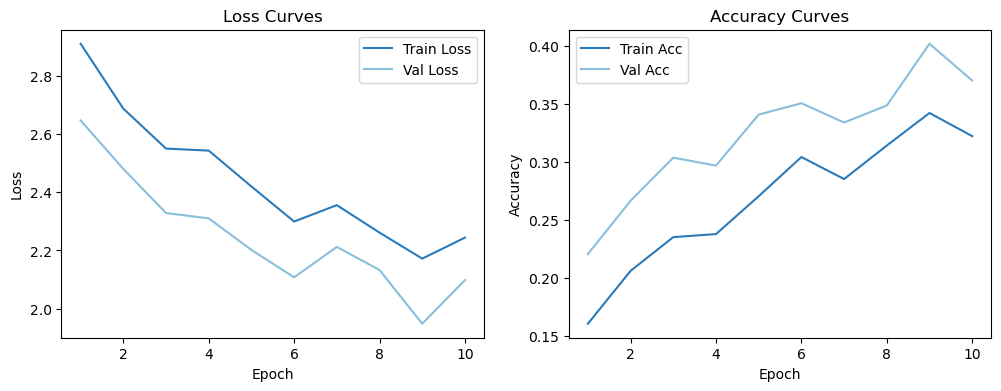

[INFO] Snapshot Ensemble Evaluation:


In [ ]:
# Step 6: train with snapshot ensemble boosting (optimized for laptop hardware)
boosted_model = EConvNeXt(num_classes=config.NUM_CLASSES, variant=config.MODEL_VARIANT).to(device)
boosted_history, snapshot_paths, training_time = train_model_with_snapshots(
    boosted_model, train_loader, val_loader, config, device, n_snapshots=3
)
plot_training_history(boosted_history)

print('[INFO] Snapshot Ensemble Evaluation:')


Loading 3 snapshot models for ensemble...


C:\Users\Rahfi\AppData\Local\Temp\ipykernel_18424\2133244604.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device


Ensemble Prediction Results:
Ensemble inference time: 28.23s
Average time per batch: 0.4411s

Ensemble Classification Report:
                 precision    recall  f1-score   support

          Clams       0.34      0.18      0.23        74
         Corals       0.30      0.29      0.30        75
          Crabs       0.44      0.66      0.53        74
        Dolphin       0.33      0.64      0.44       117
            Eel       0.00      0.00      0.00        74
           Fish       0.08      0.01      0.02        74
     Jelly Fish       0.50      0.75      0.60       126
        Lobster       0.34      0.30      0.32        74
    Nudibranchs       0.19      0.27      0.22        75
        Octopus       0.19      0.08      0.12        84
          Otter       0.65      0.68      0.66        75
        Penguin       0.25      0.25      0.25        72
        Puffers       0.20      0.06      0.10        79
       Sea Rays       0.33      0.09      0.14        77
    Sea Urchins  

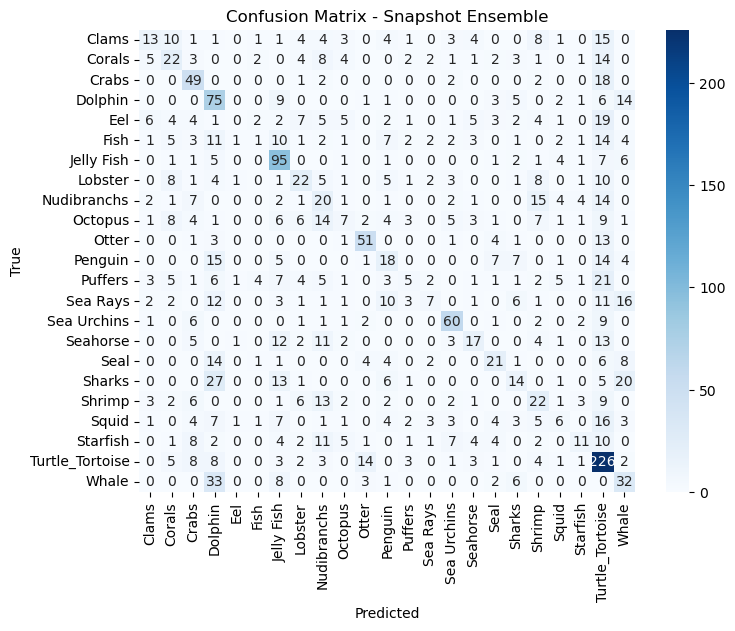


Snapshot Ensemble Accuracy: 0.3881


In [15]:
# Step 7: evaluate the snapshot ensemble
ensemble_acc = evaluate_ensemble(
    snapshot_paths, config.NUM_CLASSES, config.MODEL_VARIANT, 
    val_loader, class_names, device
)

In [ ]:
# Step 8: optional inference on a single image using ensemble
# Uncomment to test on a specific image:
# image_path = '/path/to/your/image.jpg'
# predict_image(boosted_model, image_path, config, class_names, device, topk=5)